# Outlier Detection with Hampel Filter

Recently I stumbled upon a new (to me) outlier detection algorithm - the Hampel filter. In this short article, I would like to describe how it works and how to use it in practice. To the best of my knowledge, there is no Python library containing this algorithm, so we will implement it from scratch using two different approaches (`for-loop` and `pandas`). In the end, we will see which one performs better in terms of execution speed.

## Hampel Filter

Let's start with a quick theoretical introduction. There is not a lot of online resources describing the algorithm (even no page on Wikipedia), but it is simple enough to quickly understand the logic. Also, I put some references at the end of the article.

The goal of the Hampel filter is to identify and replace outliers in a given series. It uses a sliding window of configurable width to go over the data. For each window (given observation and the `2 window_size` surrounding elements, `window_size` for each side), we calculate the median and the standard deviation expressed as [median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation).

For the MAD to be a consistent estimator for the standard deviation, we must multiply it by a constant scale factor *k*. The factor is dependent on the distribution, for Gaussian it is $k \approx 1.4826$

If the considered observation differs from the window median by more than *x* standard deviations, we treat it as an outlier and replace it with the median.

The Hampel filter has two configurable parameters:

* the size of the sliding window
* the number of standard deviations which identify the outlier

We select these two parameters depending on the use-case. A higher standard deviation threshold makes the filter more forgiving, a lower one identifies more points as outliers. Setting the threshold to 0 corresponds to John Tukey's median filter.

As the filter uses a sliding window, it makes the most sense to use it with time-series data, where the order of the data is governed by time.

## Python Implementation

### Import libraries

The first step is importing the required libraries.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np 

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

###  Random walk with outliers

Before implementing the algorithm, we create an artificial dataset using [random walk](https://en.wikipedia.org/wiki/Random_walk). We define a function that accepts the percentage of outliers as a parameter and randomly scales some random walk increments by a constant multiplier.

In [3]:
def random_walk_with_outliers(origin, n_steps, perc_outliers=0.0, outlier_mult=10, seed=42):
    '''
    Function for generating a random time series based on random walk.
    It adds a specified percentage of outliers by multiplying the random walk step by a scalar.
    
    Parameters
    ------------
    origin : int
        The starting point of the series
    n_steps : int
        Lenght of the series
    perc_outliers : float
        Percentage of outliers to introduce to the series [0.0-1.0]
    outlier_mult : float
        Scalar by which to multiply the RW increment to create an outlier
    seed : int
        Random seed

    Returns
    -----------
    rw : np.ndarray
        The generated random walk series with outliers
    indices : np.ndarray
        The indices of the introduced outliers 
    '''
    assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)
    
    #set seed for reproducibility
    np.random.seed(seed)
    
    # possible steps
    steps = [-1, 1]

    # simulate steps
    steps = np.random.choice(a=steps, size=n_steps-1)
    rw = np.append(origin, steps).cumsum(0)
    
    # add outliers
    n_outliers = int(np.round(perc_outliers * n_steps, 0))
    indices = np.random.randint(0, len(rw), n_outliers)
    rw[indices] = rw[indices] + steps[indices + 1] * outlier_mult
    
    return rw, indices
 

Using the function we generate artificial data and plot it below, together with the introduced outliers.

In [24]:
rw, outlier_ind = random_walk_with_outliers(0, 1000, 0.01)

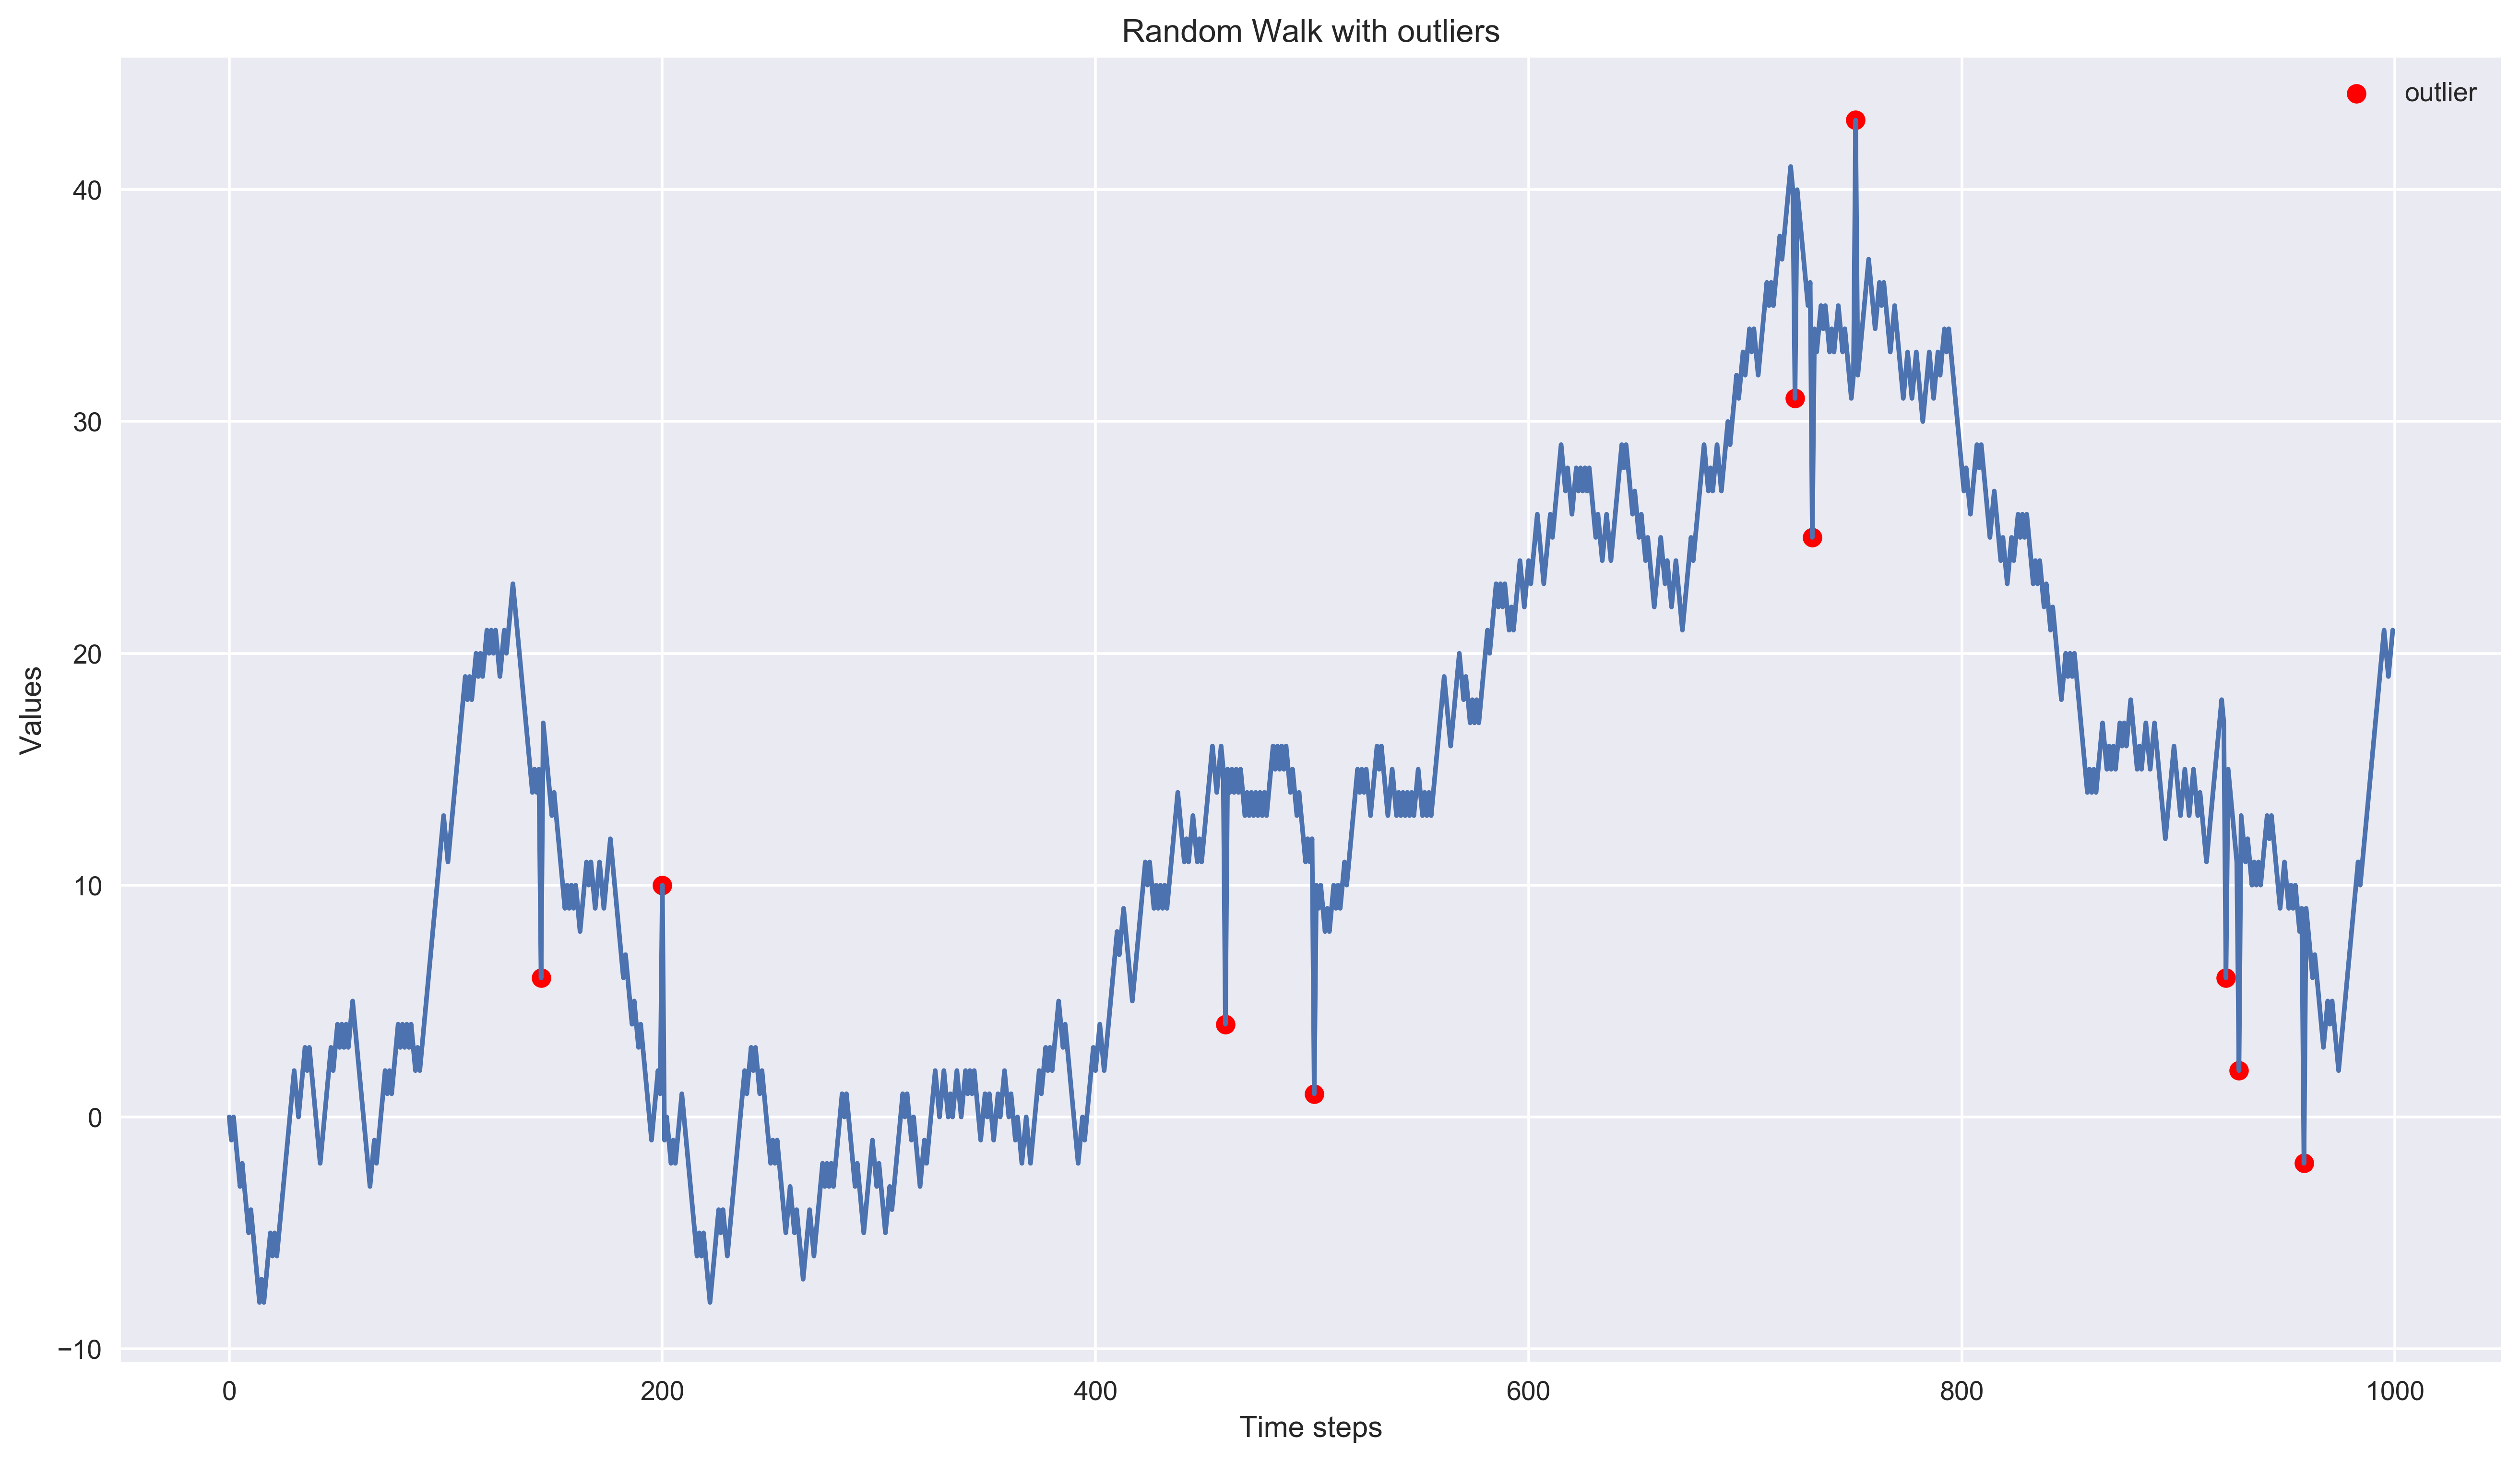

In [5]:
# Plot the path
plt.plot(np.arange(len(rw)), rw)
plt.scatter(outlier_ind, rw[outlier_ind], c='r', label='outlier')
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

### Evaluating the results

We also need to define a function for evaluating the results of our outlier detection algorithms. For that we will plot the actual vs. detected outliers and return a short summary of the performance.

In [6]:
def evaluate_detection(series, true_indices, detected_indices):
    '''
    Function for evaluating the results of the outlier detection algorithm.
    Compares the series and presents the correctly identified outliers, the false 
    positives (non-outlier observations considered outliers) and the false negatives
    (missed outliers).
    
    Parameters
    ------------
    series : np.ndarray
        The series on which outlier detection was performed
    true_indices : np.ndarray
        The array containing outlier indices (ground truth)
    detected_indices : np.ndarray
        The array containing the indices of detected outliers

    Returns
    -----------
    tp : np.ndarray
        The array containing the indices of correctly detected outliers
    fp : np.ndarray
        The array containing the indices of incorrectly detected outliers 
    fn : np.ndarray
        The array containing the indices of missed outliers
    '''
    # calculate metrics
    tp = list(set(detected_outliers).intersection(set(true_indices)))
    fp = list(set(detected_outliers).difference(set(true_indices)))
    fn = list(set(true_indices).difference(set(detected_outliers)))
    perc_detected = 100 * len(tp) / len(true_indices)
    
    # create the plot
    fix, ax = plt.subplots(2, 1)
    
    ax[0].plot(np.arange(len(series)), series);
    ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier')
    ax[0].set_title('Original series')
    ax[0].legend()
    
    ax[1].plot(np.arange(len(series)), series);
    ax[1].scatter(tp, series[tp], c='g', label='true positive')
    ax[1].scatter(fp, series[fp], c='r', label='false positive')
    ax[1].scatter(fn, series[fn], c='k', label='false negative')
    ax[1].set_title('Algorithm results')
    ax[1].legend()
    
    # print out summary
    print('-' * 25 + ' Summary ' + '-' * 25)
    print(f'Outliers in the series: {len(true_indices)}')
    print(f'Identified outliers: {len(detected_indices)}')
    print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f}% of all outliers).')
    print('-' * 59)
    
    return tp, fp, fn

### Hampel filter implementation

#### `for-loop` implementation

We start with the `for-loop` implementation of the Hampel filter. We base the code on the one from the `pracma` R package. 

In [7]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    '''
    Function for outlier detection using the Hampel filter.
    Based on `pracma` implementation in R.
    
    Parameters
    ------------
    input_series : np.ndarray
        The series on which outlier detection will be performed
    window_size : int
        The size of the window (one-side). Total window size is 2*window_size+1
    n_sigmas : int
        The number of standard deviations used for identifying outliers

    Returns
    -----------
    new_series : np.ndarray
        The array in which outliers were replaced with respective window medians
    indices : np.ndarray
        The array containing the indices of detected outliers
    '''
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

We run the algorithm on the RW series. We chose window size 10, but this should be determined empirically for the best performance.

In [25]:
res, detected_outliers = hampel_filter_forloop(rw, 10)

We evaluate the results using the previously defined helper function.

------------------------- Summary -------------------------
Outliers in the series: 10
Identified outliers: 9
Correctly detected outliers: 8 (80.00% of all outliers).
-----------------------------------------------------------


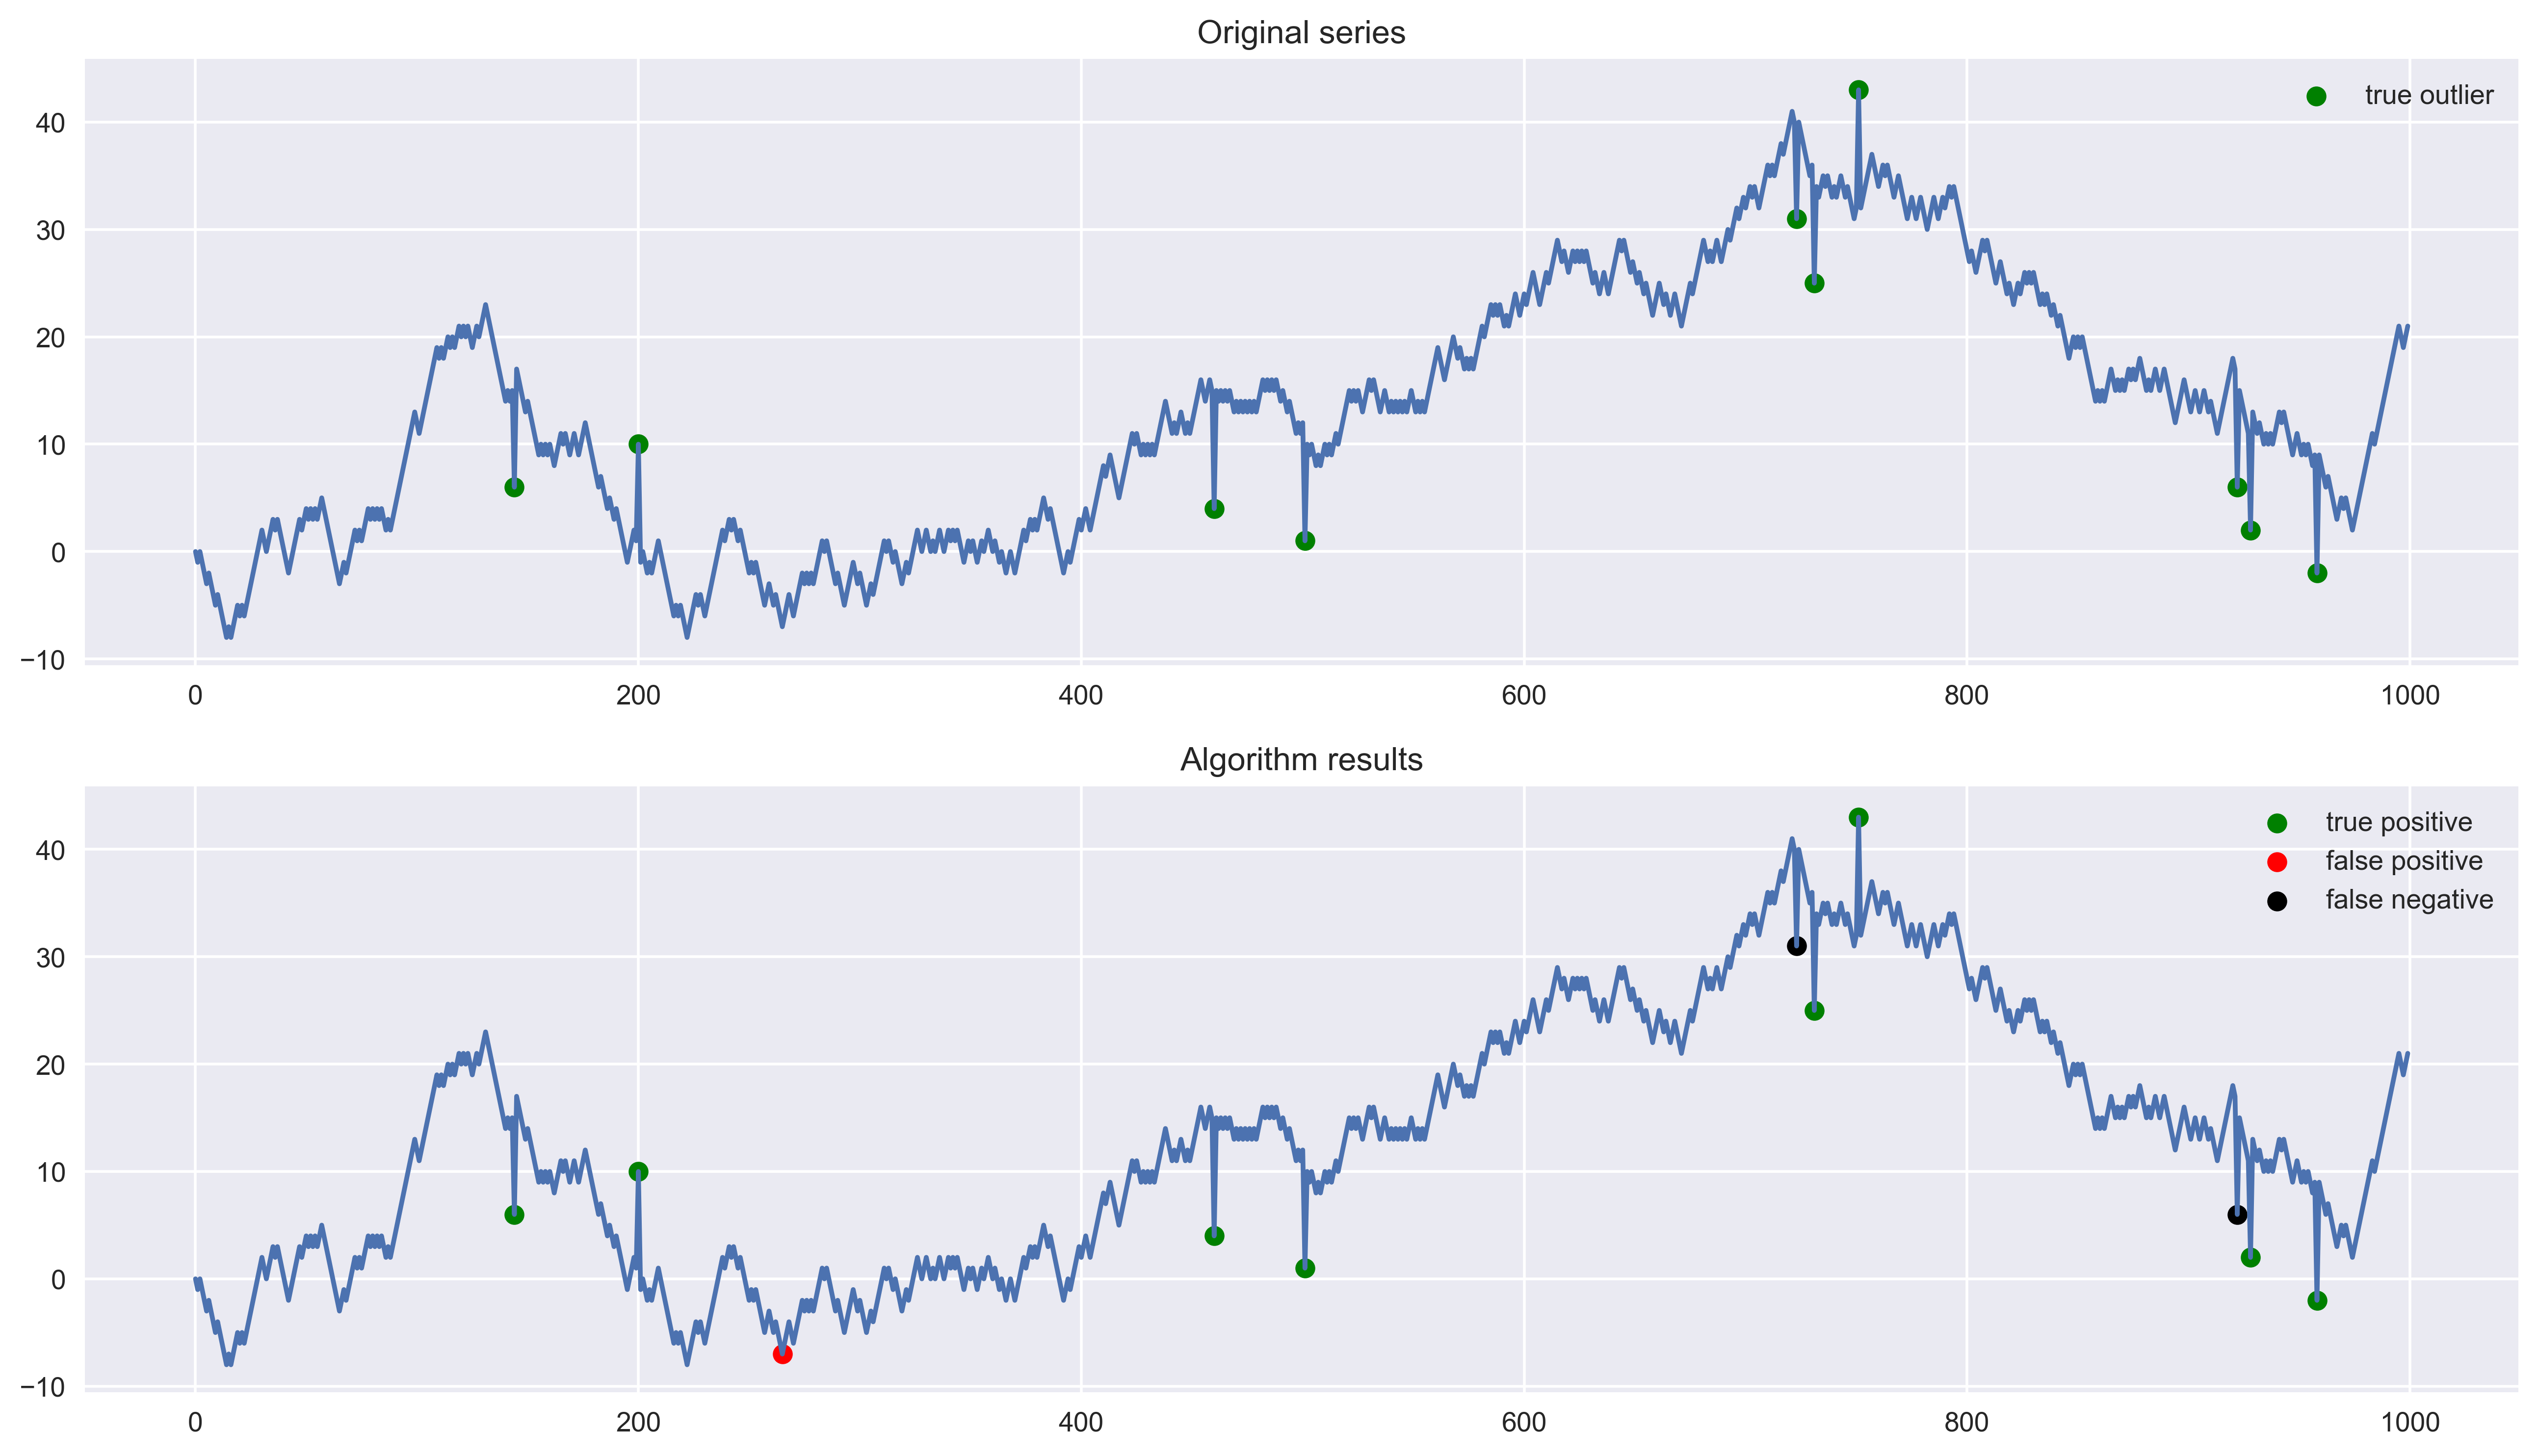

In [9]:
tp, fp, fn = evaluate_detection(rw, outlier_ind, detected_outliers)

In the plot we can see that the algorithm correctly identified 8 (out of 10) outliers, mistook one observation for an outlier (red dot) and missed 2 outliers (black dots). Perhaps better performance can be achieved by tuning the window size. However, this is sufficient for the purpose of the exercise.

We additionally plot the transformed series, in which the outliers were replaced with the window median.

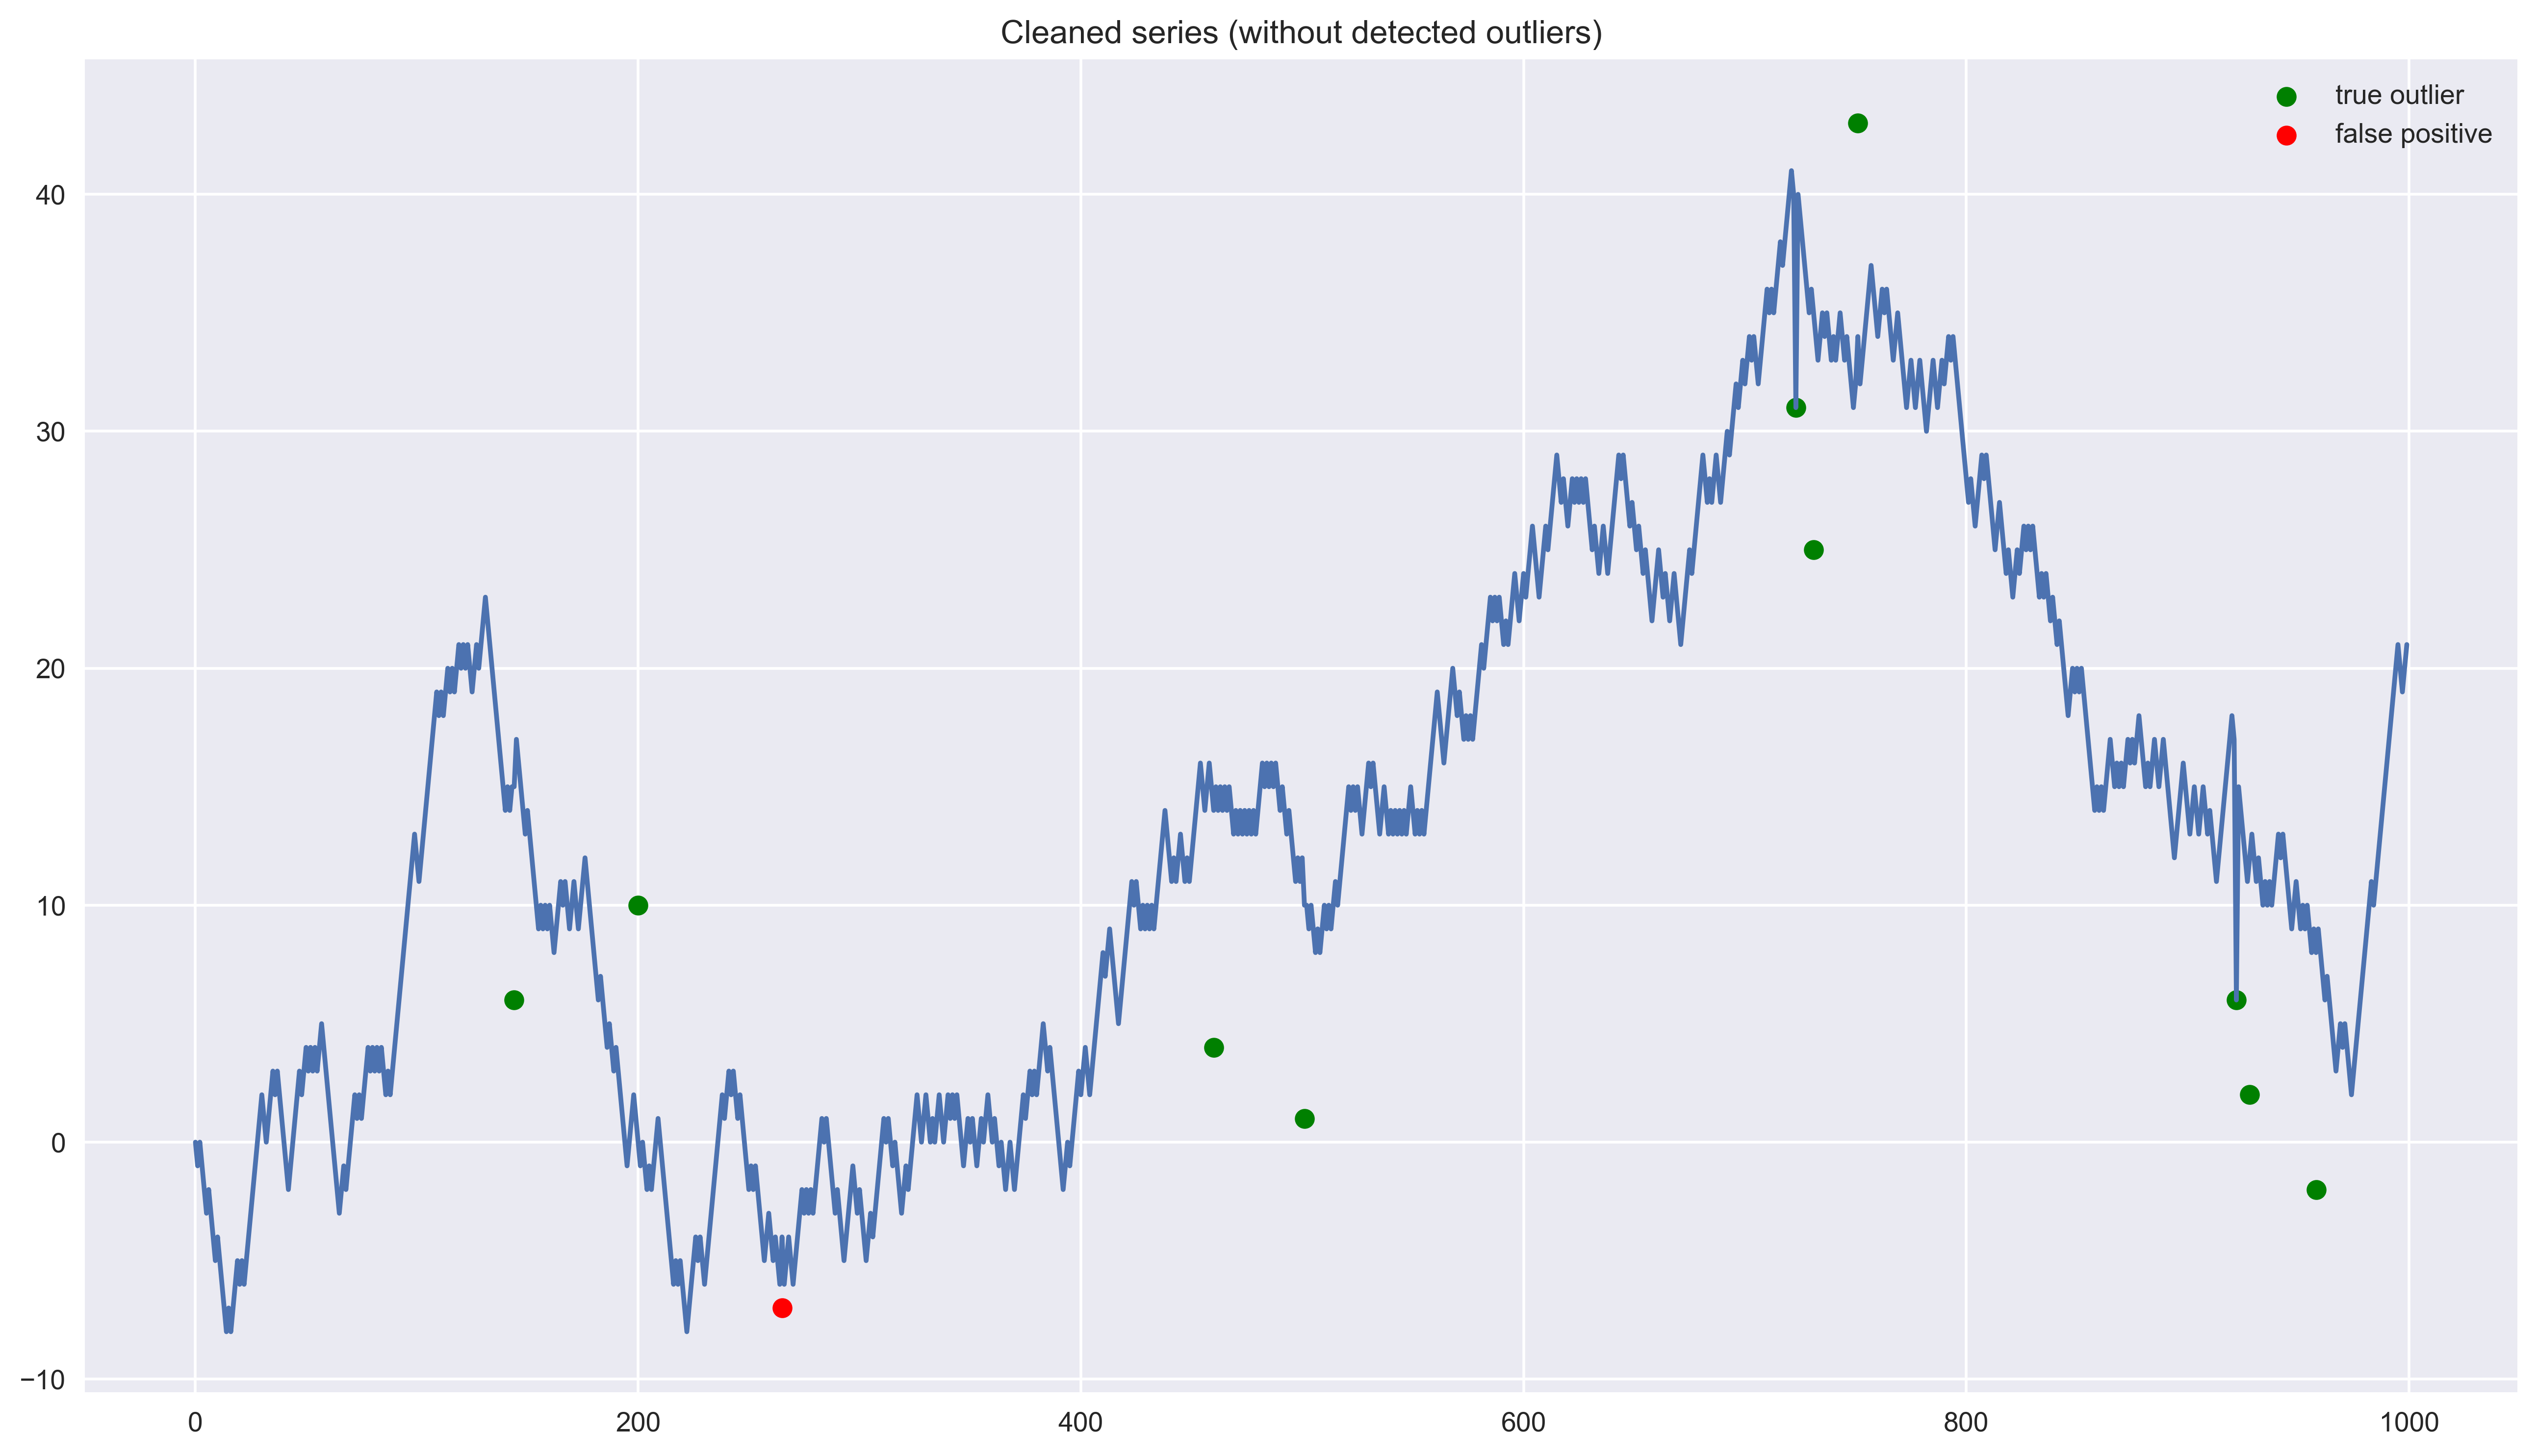

In [10]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positive')
plt.title('Cleaned series (without detected outliers)')
plt.legend();

#### `pandas` implementation

For the `pandas` implementation we make use of the `rolling` method of a `pd.Series` and a lambda function.

In [11]:
def hampel_filter_pandas(input_series, window_size, n_sigmas=3):
    '''
    Function for outlier detection using the Hampel filter.
    
    Parameters
    ------------
    input_series : pd.Series
        The series on which outlier detection will be performed
    window_size : int
        The size of the window (one-side). Total window size is 2*window_size+1
    n_sigmas : int
        The number of standard deviations used for identifying outliers

    Returns
    -----------
    new_series : pd.Series
        The array in which outliers were replaced with respective window medians
    indices : np.ndarray
        The array containing the indices of detected outliers
    '''

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = np.abs(input_series - rolling_median)

    indices = list(np.argwhere(diff > (n_sigmas * rolling_mad)).flatten())
    new_series[indices] = rolling_median[indices]
    
    return new_series, indices


In the `rolling` method we specify twice the window size and use centering, so the considered observation is in the middle of a `2 * window_size + 1` window. Before running the algorithm, we make the RW `np.ndarray` a `pd.Series`.

In [12]:
rw_series = pd.Series(rw)

In [13]:
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

------------------------- Summary -------------------------
Outliers in the series: 10
Identified outliers: 9
Correctly detected outliers: 8 (80.00% of all outliers).
-----------------------------------------------------------


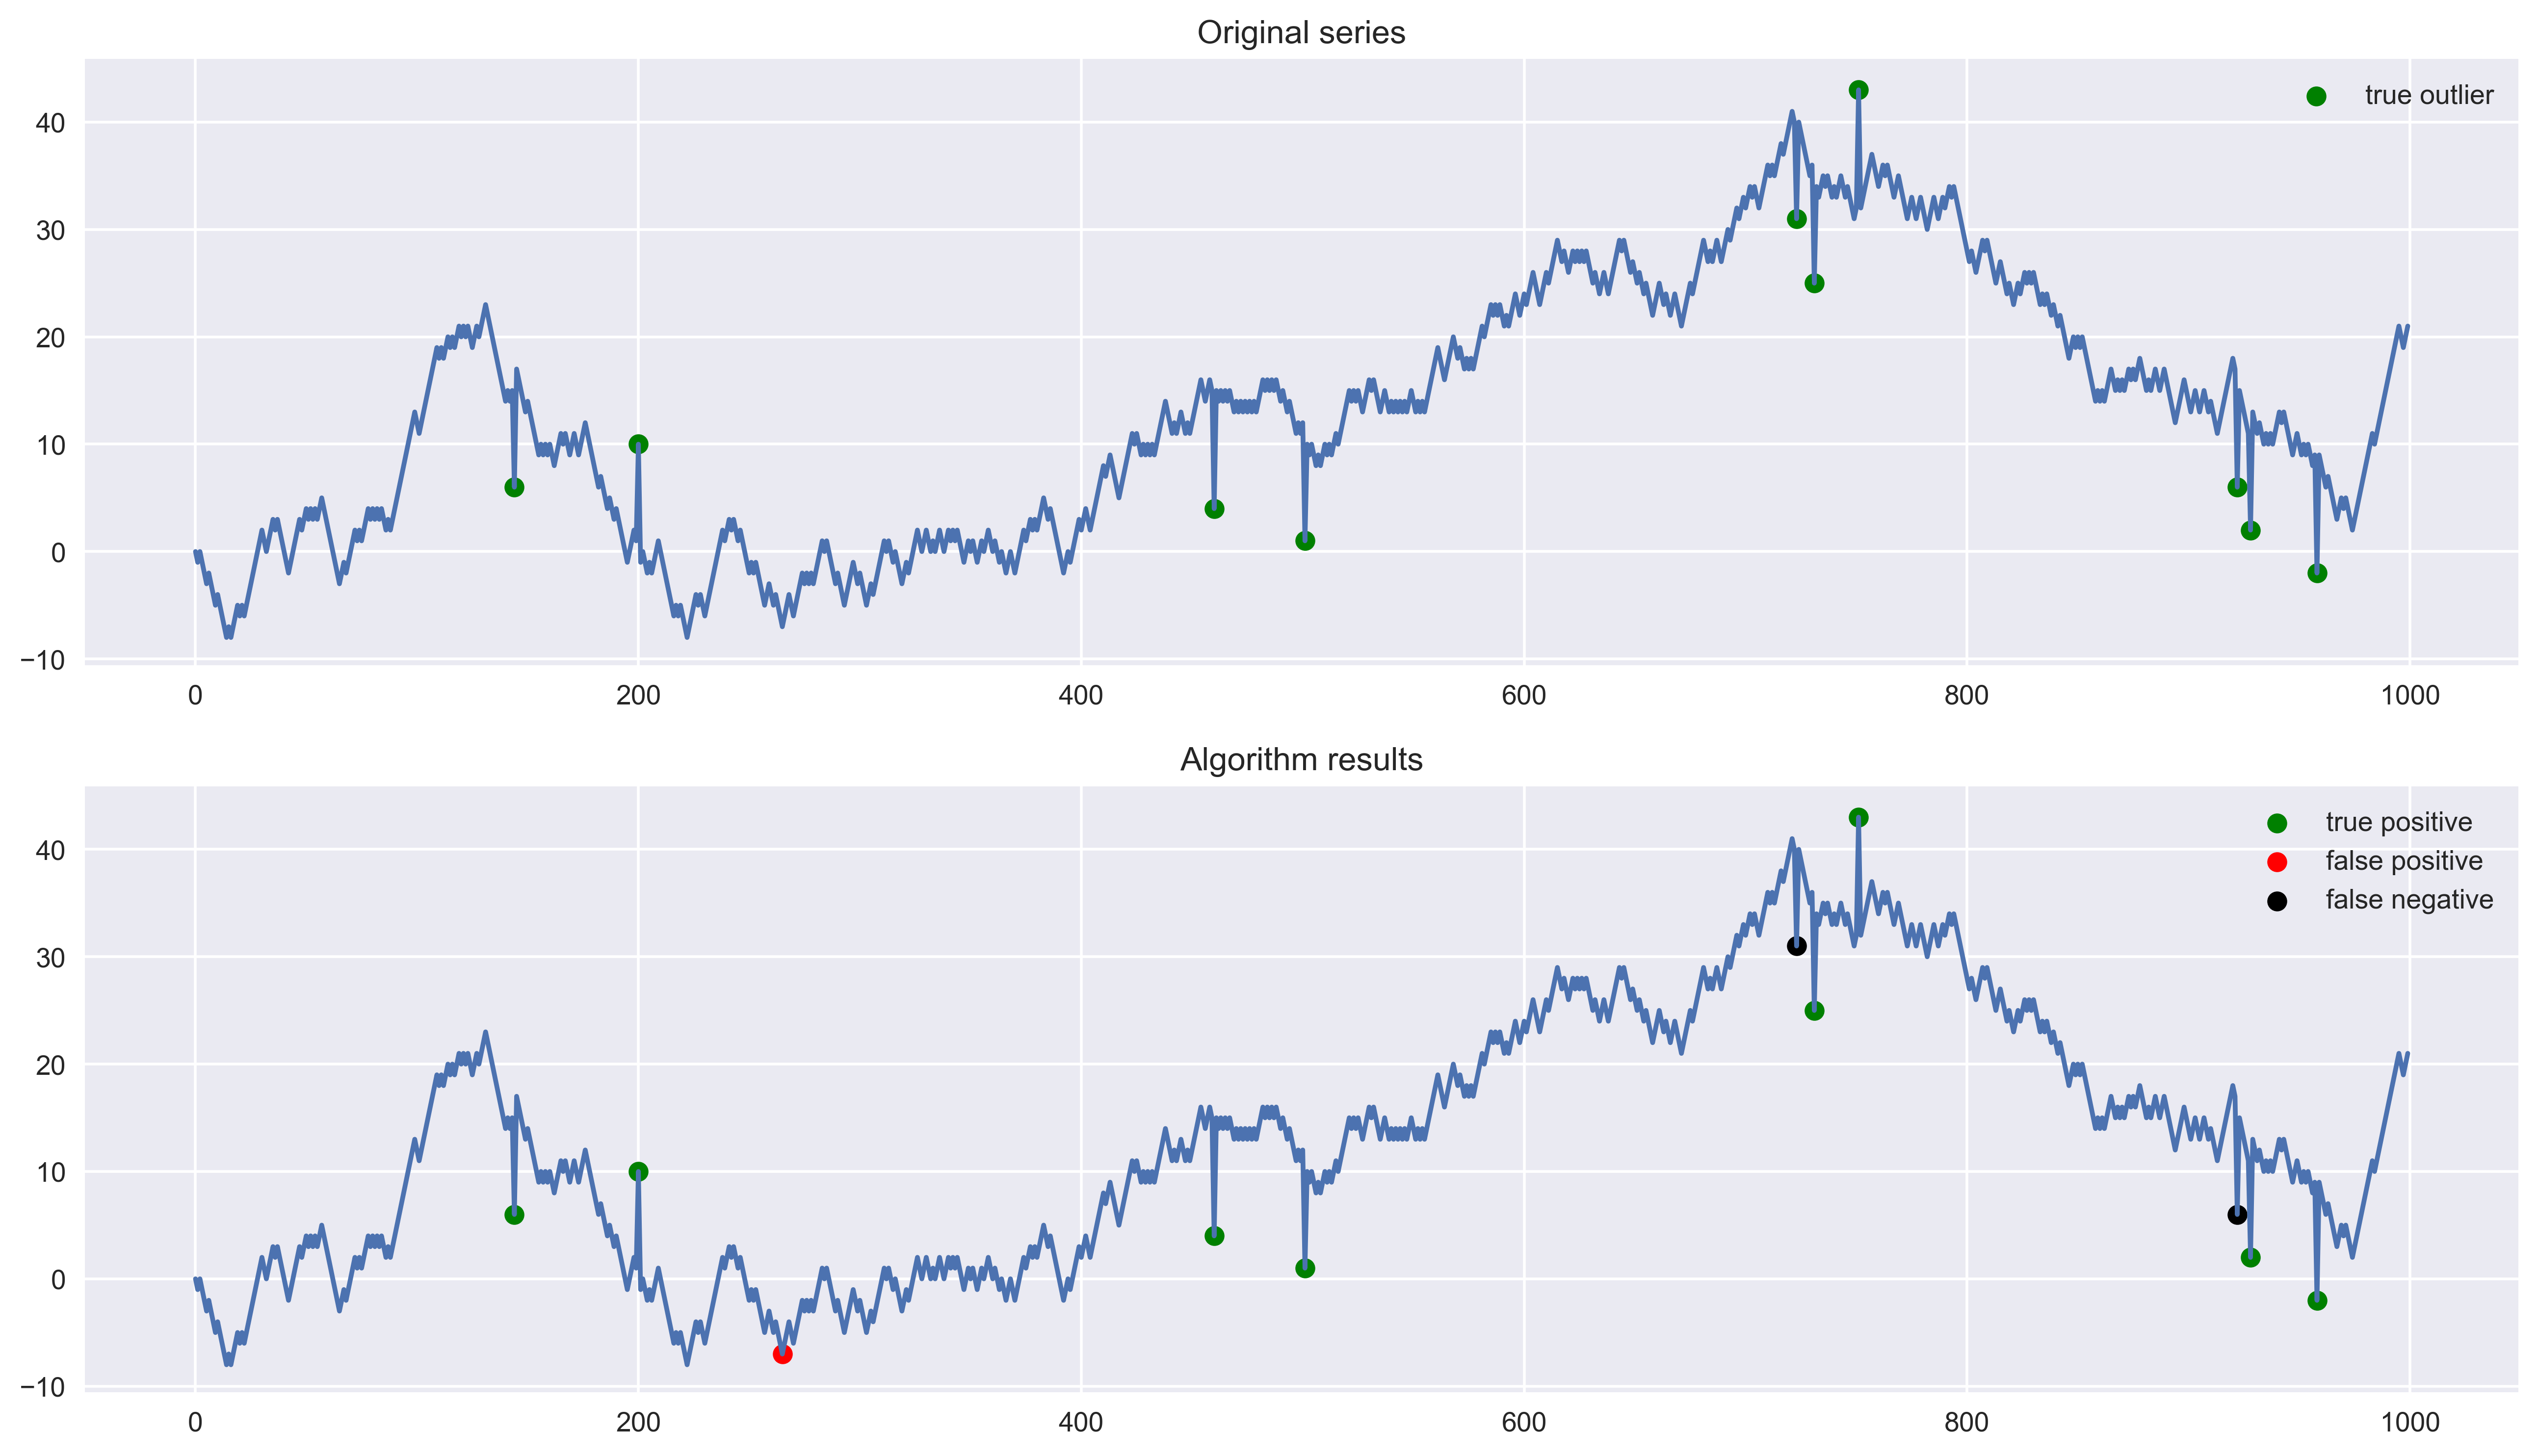

In [14]:
tp, fp, fn = evaluate_detection(rw, outlier_ind, detected_outliers)

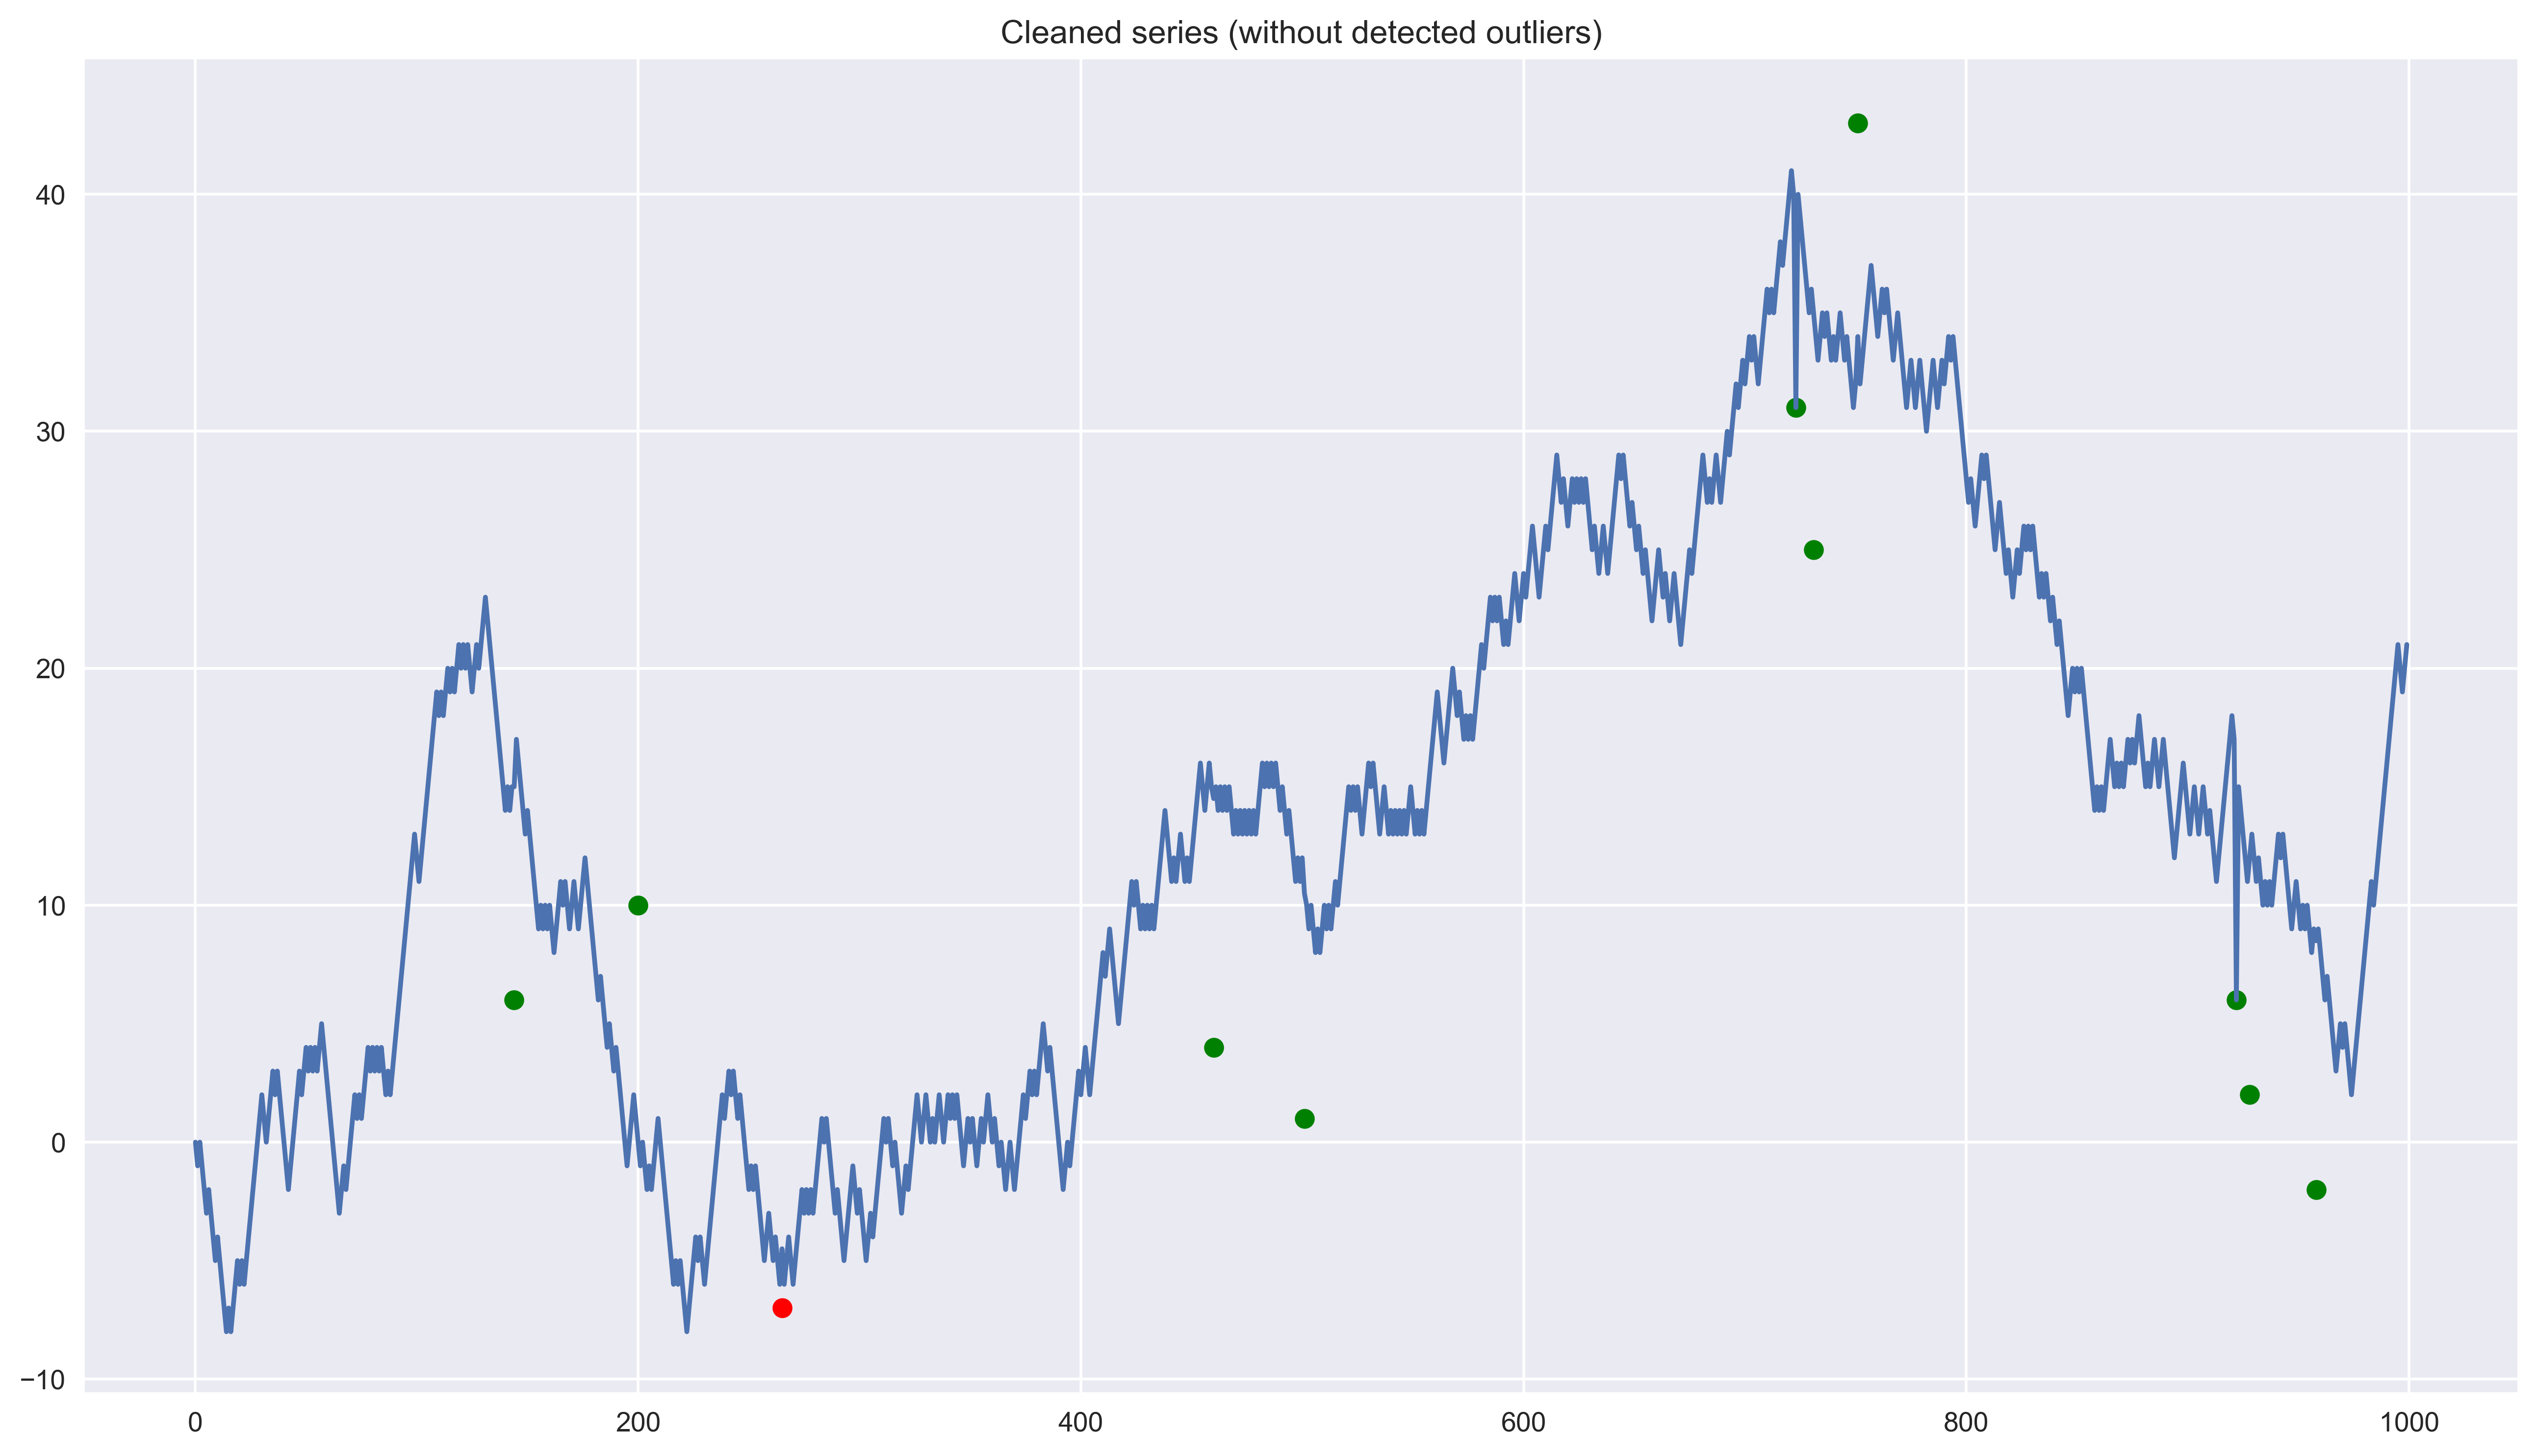

In [15]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outlier_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positives')
plt.title('Cleaned series (without detected outliers)');

The results of both approaches are identical, which is always a good sign :)

### Performance comparison 

At this point we test the two implementations against each other in terms of execution speed. We expect that the `pandas` one will perform faster.

In [16]:
%%timeit
res, detected_outliers = hampel_filter_forloop(rw, 10)

67.9 ms ± 990 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

76.1 ms ± 4.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We see that the `pandas` implementation turned out to be slower. One hypothesis to test is that the `pandas` implementation will be faster for a larger series. That is why we also increase the length of the random walk series to 100000 and test the performance once again.

In [18]:
rw, outlier_ind = random_walk_with_outliers(0, 10 ** 5, 0.01)
rw_series = pd.Series(rw)

In [19]:
%%timeit
res, detected_outliers = hampel_filter_forloop(rw, 10)

6.75 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
res, detected_outliers = hampel_filter_pandas(rw_series, 10)

6.76 s ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It turns out that now they achieved comparable performance, with the `pandas` implementation providing more stable performance (lower standard deviation).

#### Bonus: Increasing the speed of the for-loops with `numba`

As a bonus we explore the possibility of speeding up the code based on for-loops with `numba`. `numba` is a library that under-the-hood translates Python code into an optimized machine code. Given it is possible to transform the code, `numba` can make certain algorithms written in Python approach the speed of C.

The best part about `numba` is that (if possible) the speed boost comes at a very small price in terms of coding. We need to import the library and add the `@jit` decorator before the function we want to translate to machine code.

In [21]:
from numba import jit 

In [22]:
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

The `nopython` argument indicates if we want `numba` to use purely machine code or to use some Python code if necessary. Ideally, this should always be set to `true`, as long as there are no errors returned by `numba`.

Below we test the execution speed.

In [23]:
%%timeit
res, detected_outliers = hampel_filter_forloop_numba(rw, 10)

108 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It only takes 108 ms (milliseconds) as compared to 6.76 s in case of the `pandas` implementation! That is a massive speed-up of ~63 times! 

## Conclusions

Summing up, in this article we showed explained how Hampel filter work in terms of outlier detection and how to implement it in Python. We also compared the implementations in terms of execution speed. 

It is also good to consider the drawback of the Hampel filter:
* it has problems with detecting outliers at the beginning and the end of the series - when the window is not complete (even on one side), the function does not detect possible outliers 
* it struggles to detect outliers when they are close to each other - within the window range

As always, any constructive feedback is welcome. You can reach out to me on [Twitter](https://twitter.com/erykml1) or in the comments. You can find the code used for this article on my [GitHub]().

## References

* Hampel F. R., ”The influence curve and its role in robust estimation,” Journal of the American Statistical Association, 69, 382–393, 1974
* Liu, Hancong, Sirish Shah, and Wei Jiang. “On-line outlier detection and data cleaning.” Computers and Chemical Engineering. Vol. 28, March 2004, pp. 1635–1647
* Suomela, Jukka. “Median Filtering Is Equivalent to Sorting.” 2014